In [19]:
import pandas as pd
import os, inspect
from sklearn.utils import shuffle
import numpy as np
from statsmodels.stats.weightstats import DescrStatsW
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/CFS')

In [2]:
CFS_df = pd.read_csv('cfs-2017-puf-csv.csv', sep = ',')
print(CFS_df.columns)
print(len(CFS_df))
CFS_df.head(5)

Index(['SHIPMT_ID', 'ORIG_STATE', 'ORIG_MA', 'ORIG_CFS_AREA', 'DEST_STATE',
       'DEST_MA', 'DEST_CFS_AREA', 'NAICS', 'QUARTER', 'SCTG', 'MODE',
       'SHIPMT_VALUE', 'SHIPMT_WGHT', 'SHIPMT_DIST_GC', 'SHIPMT_DIST_ROUTED',
       'TEMP_CNTL_YN', 'EXPORT_YN', 'EXPORT_CNTRY', 'HAZMAT', 'WGT_FACTOR'],
      dtype='object')
5978523


,SHIPMT_ID,ORIG_STATE,ORIG_MA,ORIG_CFS_AREA,DEST_STATE,DEST_MA,DEST_CFS_AREA,NAICS,QUARTER,SCTG,MODE,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST_GC,SHIPMT_DIST_ROUTED,TEMP_CNTL_YN,EXPORT_YN,EXPORT_CNTRY,HAZMAT,WGT_FACTOR
0,1,6,99999,06-99999,6,260,06-260,326,4,43,5,4380,391,54,60,N,N,N,N,328.3
1,2,49,482,49-482,47,314,47-314,4541,3,43,14,56,4,1524,1810,N,N,N,N,8425.3
2,3,6,348,06-348,6,348,06-348,4231,4,34,5,255,440,2,5,N,N,N,N,9120.7
3,4,6,260,06-260,6,99999,06-99999,212,4,11,5,250,44912,30,35,N,N,N,N,20.9
4,5,45,273,45-273,45,273,45-273,45431,4,19,5,46,73,9,11,N,N,N,H,1733.8


In [3]:
# load additional input data
# io_2017 = read_csv('data_2017io_filtered.csv')
naics_lookup = pd.read_csv('corresp_naics6_n6io_sctg_revised.csv')
sctg_group_lookup = pd.read_csv('SCTG_Groups_revised.csv')
sctg_group_lookup.loc[:, 'SCTG_Code'] = sctg_group_lookup.loc[:, 'SCTG_Code'].astype(str)
sctg_group_lookup.loc[:, 'SCTG_Code'] = sctg_group_lookup.loc[:, 'SCTG_Code'].str.zfill(2)
need_faf_adjustment = 0
faf_benchmark = read_csv('FAF5_2017_benchmark.csv')
faf_benchmark.head(5)


,SCTG,FAF_Load
0,1,8.853321e+04
1,2,1.160428e+06
2,3,6.138867e+05
3,4,3.982516e+05
4,5,9.014731e+04


In [4]:
# clean CFS data

df_clean = CFS_df.loc[CFS_df.EXPORT_YN == 'N'] # Cleans out international exports
lb_to_ton = 0.0005

df_clean.loc[df_clean['SCTG'] == '15-19', 'SCTG'] = '16'
# value_density_by_sctg_zone.loc[value_density_by_sctg_zone['SCTG'] == '15-19', 'SCTG'] = '16'
to_drop = ['35-38', '25-30', '31-34', '10-14', '06-09', 
           '20-24', '01-05', '39-43']
df_clean = \
df_clean[~df_clean['SCTG'].isin(to_drop)]

df_clean = pd.merge(df_clean, sctg_group_lookup,
                   left_on = 'SCTG', right_on = 'SCTG_Code', how = 'left')

df_clean.loc[:, 'SHIPMT_WGHT_scaled'] = df_clean.loc[:, 'SHIPMT_WGHT'] * \
df_clean.loc[:, 'WGT_FACTOR'] * lb_to_ton # in tons
df_clean.loc[:, 'SHIPMT_VALUE_scaled'] = df_clean.loc[:, 'SHIPMT_VALUE'] * df_clean.loc[:, 'WGT_FACTOR']
df_clean.loc[:, 'unitcost'] = df_clean.loc[:, 'SHIPMT_VALUE'] / \
df_clean.loc[:, 'SHIPMT_WGHT'] / lb_to_ton # in $/ton

print(df_clean.loc[:, 'SHIPMT_WGHT_scaled'].sum() * 2000)
print(df_clean.loc[:, 'SHIPMT_VALUE_scaled'].sum() / 1000000)

df_clean_by_sctg_group = df_clean.groupby('SCTG_Name')[['SHIPMT_WGHT_scaled']].sum()
df_clean_by_sctg_group = df_clean_by_sctg_group.reset_index()
df_clean_by_sctg_group
# def removeOutliers(sName, df):
#     # Computing IQR
#     Q1 = df[sName].quantile(0.25)
#     Q3 = df[sName].quantile(0.75)
#     IQR = Q3 - Q1

#     # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
#     filtered = df.query(sName + '<= (@Q3 + 3 * @IQR)')
    
#     return filtered

# df_clean = removeOutliers('SHIPMT_WGHT', df_clean)
# df_clean = removeOutliers('SHIPMT_DIST_GC', df_clean)
# print(len(df_clean))

23494620730114.6
13376529.6025616


,SCTG_Name,SHIPMT_WGHT_scaled
0,bulk,4.378851e+09
1,fuel_fert,3.436001e+09
2,interm_food,1.412606e+09
3,mfr_goods,1.933233e+09
4,other,5.815085e+08


### output 1 -- value density by SCTG

In [5]:
# estimate value density -- no region code
faf_benchmark.loc[:, 'SCTG'] = faf_benchmark.loc[:, 'SCTG'].astype(str)
faf_benchmark.loc[:, 'SCTG'] = faf_benchmark.loc[:, 'SCTG'].str.zfill(2)
value_density_by_sctg = df_clean.groupby(['SCTG'])[['SHIPMT_WGHT_scaled', 'SHIPMT_VALUE_scaled']].sum()
value_density_by_sctg = value_density_by_sctg.reset_index()

if need_faf_adjustment == 1:
    value_density_by_sctg = pd.merge(value_density_by_sctg,
                                     faf_benchmark,
                                     on = 'SCTG',
                                     how = 'left')
    value_density_by_sctg.loc[:, 'scale_factor'] = \
    value_density_by_sctg.loc[:, 'FAF_Load'] * 1000 / \
    value_density_by_sctg.loc[:, 'SHIPMT_WGHT_scaled']
    value_density_by_sctg.loc[:, 'scale_factor'] = \
    value_density_by_sctg.loc[:, 'scale_factor'].fillna(1)
    value_density_by_sctg.loc[:, 'SHIPMT_WGHT_scaled'] *= value_density_by_sctg.loc[:, 'scale_factor']
# results_to_check = pd.merge(value_density_by_sctg, sctg_group_lookup,
#                    left_on = 'SCTG', right_on = 'SCTG_Code', how = 'left')
# df_clean_by_sctg_group = results_to_check.groupby('SCTG_Name')[['SHIPMT_WGHT_scaled', 'FAF_Load']].sum()
# df_clean_by_sctg_group = df_clean_by_sctg_group.reset_index()
# df_clean_by_sctg_group
                                  
# value_density_by_sctg.head(10)
value_density_by_sctg.loc[:, 'unitcost'] = value_density_by_sctg.loc[:, 'SHIPMT_VALUE_scaled'] / \
value_density_by_sctg.loc[:, 'SHIPMT_WGHT_scaled'] # in $/ton

value_density_by_sctg = value_density_by_sctg[['SCTG', 'unitcost']]
value_density_by_sctg.columns = ['Commodity_SCTG', 'UnitCost']
value_density_by_sctg.to_csv('data_unitcost_cfs2017.csv', index = False)

# value_density_by_sctg.head(5)

In [9]:
def weighted_std(df):
    stats = DescrStatsW(df['unitcost'], weights=df['SHIPMT_WGHT_scaled'], ddof=1)
    w_mean = stats.mean
    w_std = stats.std
    return(pd.Series([w_mean, w_std]))
value_density_by_sctg_2 = df_clean.groupby(['SCTG']).apply(weighted_std) 
value_density_by_sctg_2 = value_density_by_sctg_2.reset_index()
value_density_by_sctg_2.head(10)

,SCTG,0,1
0,00,654.388298,10960.923868
1,01,2303.976289,7669.093378
2,01-05,244.701008,938.520429
3,02,151.905213,316.533528
4,03,787.351637,8916.220077
5,04,404.383378,1519.481372
6,05,3874.318295,4812.683942
7,06,1552.698054,3482.067426
8,06-09,503.060907,1737.033675
9,07,1149.043617,6159.501996


In [6]:
# generate price by origin/seller zone
print(df_clean['SCTG'].unique())
value_density_by_sctg_zone = df_clean.groupby(['SCTG', 'ORIG_CFS_AREA'])[['SHIPMT_WGHT_scaled', 'SHIPMT_VALUE_scaled']].sum()

value_density_by_sctg_zone = value_density_by_sctg_zone.reset_index()
value_density_by_sctg_zone.loc[:, 'unitcost'] = value_density_by_sctg_zone.loc[:, 'SHIPMT_VALUE_scaled'] / \
value_density_by_sctg_zone.loc[:, 'SHIPMT_WGHT_scaled']
# value_density_by_sctg_zone.loc[value_density_by_sctg_zone['SCTG'] == '15-19', 'SCTG'] = '16'
# # value_density_by_sctg_zone.loc[value_density_by_sctg_zone['SCTG'] == '15-19', 'SCTG'] = '16'
# to_drop = ['35-38', '25-30', '31-34', '10-14', '06-09', 
#            '20-24', '01-05', '39-43']
value_density_by_sctg_zone = \
value_density_by_sctg_zone[~value_density_by_sctg_zone['SCTG'].isin(to_drop)]
value_density_by_sctg_zone = value_density_by_sctg_zone[['SCTG', 'ORIG_CFS_AREA', 'SHIPMT_WGHT_scaled', 'unitcost']]
value_density_by_sctg_zone.columns = ['Commodity_SCTG', 'ORIG_CFS_AREA', 'Capacity', 'UnitCost']

value_density_by_sctg_zone.head(5)
value_density_by_sctg_zone.to_csv('data_unitcost_by_zone_cfs2017.csv', index = False)

['43' '34' '11' '19' '40' '36' '33' '38' '28' '35' '37' '26' '24' '32'
 '18' '20' '21' '07' '39' '04' '27' '08' '41' '30' '06' '23' '31' '29'
 '25' '05' '12' '13' '03' '10' '17' '22' '09' '02' '14' '01' '16' '15'
 '00']


### Output 2 -- shipment weight cut point

In [12]:
def weighted_quantile(df, quantile=0.5):
    df_sorted = df.sort_values('SHIPMT_WGHT')
    cumsum = df_sorted['SHIPMT_WGHT_scaled'].cumsum()
    cutoff = df_sorted['SHIPMT_WGHT_scaled'].sum() * quantile
    value = df_sorted[cumsum >= cutoff]['SHIPMT_WGHT'].iloc[0]
    return(value)
load_by_sctg = df_clean.groupby(['SCTG']).apply(weighted_quantile)
load_by_sctg = load_by_sctg.reset_index()
# load_by_sctg.loc[load_by_sctg['SCTG'] == '15-19', 'SCTG'] = '16'
# load_by_sctg = load_by_sctg[~load_by_sctg['SCTG'].isin(to_drop)]
# load_by_sctg = df_clean.groupby(['SCTG'])[['SHIPMT_WGHT']].quantile(0.9)

load_by_sctg.columns = ['Commodity_SCTG', 'SHIPMT_WGHT']
# value_density_by_sctg.loc[:, 'unitcost'] = value_density_by_sctg.loc[:, 'SHIPMT_VALUE_scaled'] / \
# value_density_by_sctg.loc[:, 'SHIPMT_WGHT_scaled']

# value_density_by_sctg = value_density_by_sctg[['SCTG', 'unitcost']]
# value_density_by_sctg.columns = ['Commodity_SCTG', 'UnitCost']
load_by_sctg.to_csv('max_load_per_shipment_50percent.csv', index = False)
load_by_sctg.head(5)

,Commodity_SCTG,SHIPMT_WGHT
0,00,191836
1,01,42667
3,02,61436
4,03,53481
5,04,49567


In [8]:
# check sample size by sctg
count_by_sctg = df_clean.groupby(['SCTG'])[['SHIPMT_WGHT']].count()
count_by_sctg.columns = ['sample_size']
count_by_sctg = count_by_sctg.reset_index()
print(count_by_sctg)


   SCTG  sample_size
0    00          300
1    01         3186
2    02        32190
3    03        75420
4    04        66779
5    05       101036
6    06        95145
7    07       259712
8    08       149181
9    09        16390
10   10         7188
11   11        36472
12   12        99289
13   13        27817
14   14         4604
15   15         7825
16   16          901
17   17        56993
18   18        82046
19   19       153820
20   20       125965
21   21       135918
22   22        29358
23   23       189641
24   24       322876
25   25         4102
26   26       205993
27   27        74355
28   28       108952
29   29       208014
30   30       297253
31   31       197201
32   32       223501
33   33       263385
34   34       334578
35   35       367211
36   36       287591
37   37        42333
38   38       139785
39   39       124687
40   40       354525
41   41        38759
42   43       400068


### Output 3 --- shipment value allocation factor by zone

In [9]:
# generate fraction of value by zone 
value_fraction_by_origin = df_clean.groupby(['SCTG', 'ORIG_CFS_AREA'])[['SHIPMT_VALUE_scaled']].sum()
value_fraction_by_origin = value_fraction_by_origin.reset_index()

# value_fraction_by_origin.head(20)

value_fraction_by_dest = df_clean.groupby(['SCTG', 'DEST_CFS_AREA'])[['SHIPMT_VALUE_scaled']].sum()
value_fraction_by_dest = value_fraction_by_dest.reset_index()

value_fraction_by_dest.head(20)

,SCTG,DEST_CFS_AREA,SHIPMT_VALUE_scaled
0,00,01-99999,64704.1
1,00,02-99999,47026734.5
2,00,04-38060,986343.9
3,00,05-99999,92954525.5
4,00,06-260,762399.2
5,00,06-348,3936573.5
6,00,06-41740,42453719.0
7,00,06-488,4380614.4
8,00,06-99999,386260.2
9,00,08-216,7658459.7


In [10]:
cfs_to_faf_lookup = pd.read_csv('CFS_FAF_LOOKUP.csv', sep = ',')
cfs_to_faf_lookup.head(5)
value_fraction_by_origin_faf = pd.merge(value_fraction_by_origin, 
                                        cfs_to_faf_lookup, 
                                        left_on = 'ORIG_CFS_AREA',
                                        right_on = 'ST_MA', how = 'left')

value_fraction_by_dest_faf = pd.merge(value_fraction_by_dest, 
                                        cfs_to_faf_lookup, 
                                        left_on = 'DEST_CFS_AREA',
                                        right_on = 'ST_MA', how = 'left')

value_fraction_by_origin_faf = value_fraction_by_origin_faf.dropna(subset = ['FAF'])
value_fraction_by_origin_faf.loc[:, 'value_fraction'] = value_fraction_by_origin_faf.loc[:, 'SHIPMT_VALUE_scaled'] / \
value_fraction_by_origin_faf.groupby('SCTG')['SHIPMT_VALUE_scaled'].transform('sum')


value_fraction_by_dest_faf = value_fraction_by_dest_faf.dropna(subset = ['FAF'])
value_fraction_by_dest_faf.loc[:, 'value_fraction'] = value_fraction_by_dest_faf.loc[:, 'SHIPMT_VALUE_scaled'] / \
value_fraction_by_dest_faf.groupby('SCTG')['SHIPMT_VALUE_scaled'].transform('sum')

output_attr = ['SCTG', 'FAF', 'value_fraction']
output_attr_label = ['Commodity_SCTG', 'FAF', 'value_fraction']
value_fraction_by_origin_faf = value_fraction_by_origin_faf[output_attr]
value_fraction_by_origin_faf.columns = output_attr_label

value_fraction_by_dest_faf = value_fraction_by_dest_faf[output_attr]
value_fraction_by_dest_faf.columns = output_attr_label

value_fraction_by_origin_faf.to_csv('producer_value_fraction_by_faf.csv', index = False)
value_fraction_by_dest_faf.to_csv('consumer_value_fraction_by_faf.csv', index = False)

### Output 4 --- seasonal allocation factor of shipments

In [38]:
# df_clean.loc[:, 'SCTG_Group'] = df_clean.loc[:, 'SCTG_Group'].astype(int)
shipment_by_season = df_clean.groupby(['SCTG_Group', 'SCTG_Name', 'QUARTER'])[['SHIPMT_WGHT_scaled', 'WGT_FACTOR']].sum()
shipment_by_season = shipment_by_season.reset_index()

shipment_by_season.loc[:, 'weight_fraction'] = \
shipment_by_season.loc[:, 'SHIPMT_WGHT_scaled'] / \
shipment_by_season.groupby('SCTG_Group')['SHIPMT_WGHT_scaled'].transform('sum')

shipment_by_season.loc[:, 'count_fraction'] = \
shipment_by_season.loc[:, 'WGT_FACTOR'] / \
shipment_by_season.groupby('SCTG_Group')['WGT_FACTOR'].transform('sum')
shipment_by_season.loc[:, 'SCTG_Group'] = shipment_by_season.loc[:, 'SCTG_Group'].astype(int)

shipment_by_season_out = shipment_by_season[['SCTG_Group', 'SCTG_Name', 'QUARTER', 'weight_fraction']]
shipment_by_season_out.head(5)
shipment_by_season_out.to_csv('seasonal_allocation_factor_by_sctg.csv')

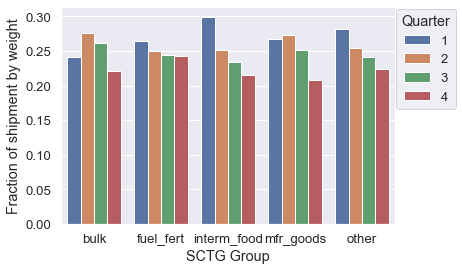

In [39]:
sns.barplot(data=shipment_by_season_out, 
            x="SCTG_Name", y="weight_fraction", hue="QUARTER")
plt.legend(loc='upper right', bbox_to_anchor=(1.2,1.02),
          title = 'Quarter')
plt.xlabel('SCTG Group')
plt.ylabel('Fraction of shipment by weight')
plt.savefig('CFS2017_seasonal_variation.png', dpi = 200, bbox_inches = 'tight')